In [1]:
# Import libraries
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize

In [2]:
# Visualize data in tabular form
df = pd.read_csv('breast-cancer.csv')
df = df.drop(['id'], axis = 1)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df['diagnosis'] = np.where(df['diagnosis'] == 'M', 1, 0)

x_, x_test, y_, y_test = train_test_split(df.drop(columns='diagnosis'), df['diagnosis'], test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_, y_, test_size=0.2, random_state=42)

y_valid

95     1
93     0
401    0
345    0
194    1
      ..
71     0
16     1
346    0
149    0
312    0
Name: diagnosis, Length: 91, dtype: int32

For practical use, we will convert the dataframe into a numpy array. Then we will create the functions necessary for logistic regression

In [4]:
x_test = x_test.to_numpy()
x_train = x_train.to_numpy()
x_valid = x_valid.to_numpy()
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()

In [5]:
print(x_train.shape)
print(y_train.shape)
print(f"input: \n{x_train}\noutput: \n{y_train}")

(364, 30)
(364,)
input: 
[[1.464e+01 1.524e+01 9.577e+01 ... 1.397e-01 3.151e-01 8.473e-02]
 [1.522e+01 3.062e+01 1.034e+02 ... 2.356e-01 4.089e-01 1.409e-01]
 [1.371e+01 1.868e+01 8.873e+01 ... 1.284e-01 2.849e-01 9.031e-02]
 ...
 [1.270e+01 1.217e+01 8.088e+01 ... 8.224e-02 2.775e-01 9.464e-02]
 [1.460e+01 2.329e+01 9.397e+01 ... 1.359e-01 2.477e-01 6.836e-02]
 [1.267e+01 1.730e+01 8.125e+01 ... 5.602e-02 2.688e-01 6.888e-02]]
output: 
[0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0
 0 0 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0
 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0
 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 

In [6]:
def sigmoid(z):
    z = z.astype(float)
    return 1/(1+np.exp(-z))

In [7]:
def logistic_cost(w, b, x, y):
    z = np.dot(x, w) + b
    out = sigmoid(z)
    out = np.clip(out, 1e-10, 1)
    return np.sum(-y*np.log(out) - (1-y)*np.log(1-out))/len(y)

In [8]:
def calculate(w, b, x):
    return np.dot(w, x) + b

In [9]:
def batch_training(w, b, x, y, iterations, alpha):

    j_history = []
    m = len(x)
    for i in range(iterations):
        z = np.dot(x, w) + b
        y_pred = sigmoid(z).reshape(-1, 1)
        dj_df = (y_pred - y.reshape(-1, 1))/m
        dj_dw = np.dot(np.transpose(x), dj_df)
        dj_db = np.sum(dj_df)
        w -= alpha*dj_dw
        b -= alpha*dj_db

        if i < 100000:
            j_history.append(logistic_cost(w, b, x, y))
        
        if i % (iterations/10) == 0 or i == (iterations-1):
            print(f"Iteration: {i}, Cost: {float(j_history[-1]):.2f}")
            
    return w, b, j_history

In [10]:
weights = (np.random.rand(x_train.shape[1], 1) - 0.5)
bias = np.random.rand()

normalize(x_train, axis = 0)

array([[0.05300013, 0.04068852, 0.05311636, ..., 0.05587525, 0.05522244,
        0.05166754],
       [0.05509986, 0.08175082, 0.05734814, ..., 0.09423199, 0.07166123,
        0.08591946],
       [0.04963332, 0.0498728 , 0.0492118 , ..., 0.05135564, 0.04992978,
        0.05507017],
       ...,
       [0.04597689, 0.03249208, 0.044858  , ..., 0.03289321, 0.0486329 ,
        0.05771056],
       [0.05285532, 0.06218081, 0.05211803, ..., 0.05435538, 0.04341034,
        0.04168527],
       [0.04586828, 0.04618841, 0.04506321, ..., 0.0224061 , 0.04710819,
        0.04200236]])

In [12]:
j= []
weights, bias, j = batch_training(weights, bias, x_train, y_train, 1000, 0.0001)

C:\Users\rakra\AppData\Local\Temp\ipykernel_29300\2465945702.py:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(-y*np.log(out) - (1-y)*np.log(1-out))/len(y)
C:\Users\rakra\AppData\Local\Temp\ipykernel_29300\2465945702.py:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-y*np.log(out) - (1-y)*np.log(1-out))/len(y)


Iteration: 0, Cost: nan
Iteration: 100, Cost: nan
Iteration: 200, Cost: nan
Iteration: 300, Cost: nan
Iteration: 400, Cost: nan
Iteration: 500, Cost: nan
Iteration: 600, Cost: nan
Iteration: 700, Cost: nan
Iteration: 800, Cost: nan
Iteration: 900, Cost: nan
Iteration: 999, Cost: nan


[3062.4381737051813, nan, 3062.4381737051813, nan, nan, nan, 3062.4381737051813, nan, nan, nan, 3062.4381737051813, nan, 3062.4381737051813, nan, nan, nan, nan, nan, nan, nan, nan, nan, 3062.4381737051813, nan, nan, nan, nan, nan, 3062.4381737051813, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

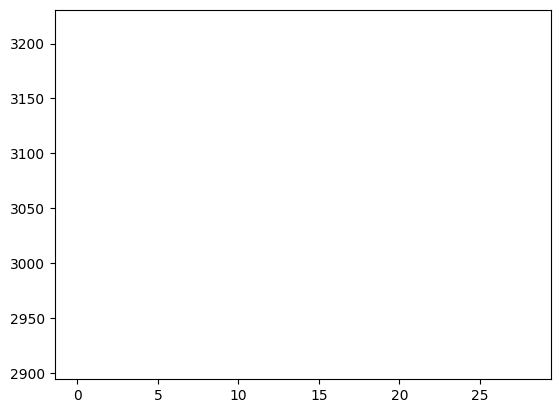

In [86]:
print(j)
plt.plot(j)